In [ ]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter

DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATCH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 15
TIME_MASK = 20

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 32
EPOCHS = 70
LEARNING_RATE = 0.002 #2e-4
WEIGHT_DECAY = 0.00001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))

all_chars = Counter("".join(train_data['message']))
BLANK_CHAR = "_"
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
num_classes = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}
int_to_char = {i: char for i, char in enumerate(vocab_list)}
BLANK_IDX = char_to_int[BLANK_CHAR]

class MosreDataset(Dataset):
    """
    Класс для обработки 
    """
    def __init__(self, df, data_patch,char_to_int, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.char_to_int = char_to_int
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            audio_file = self.audio_paths / self.df.id.values[index]
            waveform, sample_rate = torchaudio.load(audio_file)
            augmented_spectrogram = self.transforms(waveform)

            if self.is_train:
                message = self.messeges[index]
                #Получение списка индексов секта - как требует CTC los
                '''
                При обработке dataloader labels будут выравниваться по макс длине для выравнивания батча
                Т.е. будет padding 0. что в будующем будет пустым значением для ctc loss
                '''
                target = torch.tensor([self.char_to_int[char] for char in message], dtype=torch.long); 
                target_len = torch.tensor(len(target), dtype=torch.long)
                return augmented_spectrogram, target, target_len, message
            else:
                return augmented_spectrogram, None, None, None
        except Exception as ex:
            print(str(ex))
        
    def change_time(self, audio_file, max_len = 384000):
        waveform, sample_rate = torchaudio.load(audio_file)
        cahanal, sig_len = waveform.shape

        if sig_len < max_len:
            pad_len = torch.zeros(max_len - sig_len).unsqueeze(0)
            waveform = torch.cat([waveform, pad_len], dim=1)

        return waveform
    
FIRST_FE_COUNT = 16
SECOND_FE_COUNT = 32
THIRD_FE_COUNT = 32
QAD_FE_COUNT = 32
PADDING = 'same'
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 256
# Start with 4 transforms
class MorseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((1, 2), (1, 2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 2), (2, 2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)) # [batch=32, QAD_FE_COUNT = 32, 8, 80](что юы сохраниить большще признаков по горизонтали)
        )
        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 356); 
            cnn_out = self.net_conv(dummy_input); 
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]

        print(f"CNN размерность выхода: {cnn_out.shape}"); 
        print(f"CNN число фичей: {self.cnn_output_features}")

        # Добавлен лоейный слой и функция активации. Для чего? расписать потом 
        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2); 
        self.gelu = nn.GELU()
        
        self.rnn = nn.LSTM(
                input_size=N_MELS*2,
                hidden_size=GRU_HIDEN,
                num_layers=2,
                bidirectional=True,
                dropout=0.3,
                batch_first=True 
            )

        
        self.embed_dim = GRU_HIDEN * 2
        self.layer_norm = nn.LayerNorm(self.embed_dim)      
        self.dropout = nn.Dropout(0.3)   
        self.layer2 = nn.Linear(self.embed_dim, num_classes)       
        # self.layer3 = nn.Linear(GRU_HIDEN, GRU_HIDEN // 2)       
        # self.layer4 = nn.Linear(GRU_HIDEN // 2, 45)             

    def forward(self, x):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]

        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=89, features/hiden_dim=512]
        x = self.layer1(x)
        x = self.gelu(x)

        self.rnn.flatten_parameters()

        x = self.rnn(x) # [batch=32, seq_len=89, features/hiden_dim=256 * 2]
        x, _ = x # берем информацию со всез состояний
        x = self.layer_norm(x)
        x = self.dropout(x)
        x = self.layer2(x) # logits - [batch, sequence, num_classes] 
        x = nn.functional.log_softmax(x.permute(1,0,2), dim=2) # pertime так как CTC loss требует на взод (sequence/T,batch/N,num_classes/C)
        '''
        по одному прогнозу для каждого из признаков в последовательности, 
        в итоге получается 89 прогнозов символов для каждой секунды звука.
        '''
        return x
    

train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK),
    # v2.RandomCrop((N_MELS, 1920)) # Обрезает последний кадр спектрограммы, в идеале надобы считать а не прописывать число
    ) # заметка - Данные трансформации не создают довых обучаемых параметров. Но есть и те что создают. В будущем это стоит учитывать

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    # v2.CenterCrop((N_MELS, 1920)) 
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.15, random_state=SEED)

train_ds = MosreDataset(df=train_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDataset(df=val_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=valid_audio_transforms)


def my_collate(batch):
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)

    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[1] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[2] for item in batch])
        msg = [item[3] for item in batch]
        
        return [spectrograms_padded, target, label_len, msg]
    else: 
        return spectrograms_padded

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)

test, test_target, _, mess = next(iter(train_dl))
test, test_target= test.to(DIVICE), test_target.to(DIVICE)

test_val, val_target, __, val_mess = next(iter(val_dl))
test_val, val_target = test_val.to(DIVICE), val_target.to(DIVICE)
# test.shape 

#===== начало обучения =====
model = MorseNet(num_classes=num_classes).to(DIVICE)
# model = DataParallel(model)
optimizer = optim.Adam(params=model.parameters(), lr=0.002)  # Было 0.002
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
loss_func = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(DIVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}")

CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 512

MorseNet - инициалицация модели. Число обучаемых параметров: 2,808,589


In [26]:
# BLANK_CHAR = "_"
# vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
# num_classes = len(vocab_list)
# char_to_int = {char: i for i, char in enumerate(vocab_list)}
# int_to_char = {i: char for i, char in enumerate(vocab_list)}
# BLANK_IDX = char_to_int[BLANK_CHAR]
# vocab_list

In [3]:
# a= model(test)
# a.shape, a

In [54]:
_.reshape(BATCH_SIZE)

tensor([ 8, 12,  7, 11,  9, 10,  8, 11,  8,  9,  8,  8, 11, 10,  9, 11, 11,  9,
         7,  8,  8,  9, 11,  8,  9,  9,  9,  8, 10,  8,  6, 11])

Подсказка по ctc loss

In [5]:
# Target are to be un-padded
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size
# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
# Initialize random batch of targets (0 = blank, 1:C = classes)
target_lengths = torch.randint(low=1, high=T, size=(N,), dtype=torch.long)
target = torch.randint(low=1, high=C, size=(sum(target_lengths),), dtype=torch.long)
ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()
# input.detach().numpy().shape
loss.grad

C:\Users\homer\AppData\Local\Temp\ipykernel_20744\2733710114.py:15: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  loss.grad


In [9]:
input.shape, target.shape

(torch.Size([50, 16, 20]), torch.Size([334]))

# Декодировщик предсказаний

In [ ]:
# a = model(test)
# a

# Обучение модели

In [2]:
import Levenshtein
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds


In [3]:
lst_loss_train = []
lst_loss_val = []
best_val_loss = 0
for epoch in range(EPOCHS):
    model.train()

    epoch_train_loss = 0.0
    train_predicts = []

    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for batch_ind, batch in enumerate(train_tqdm):
        mel_spec, targets, targets_lens, _ = batch
        mel_spec, targets, targets_lens = mel_spec.to(DIVICE), targets.to(DIVICE), targets_lens.to(DIVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        optimizer.zero_grad()
        predict = model(mel_spec) # (N=batch,T,C)
        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

    #     print("Predict shape:", predict.shape) # [T, N, C]
    #     print("Labels shape:", targets.shape)   # [N, max_label_len]
    #     print("Predict lengths:", predict_lengths) # [N]
    #     print("Target lengths:", targets_lens.reshape(BATCH_SIZE))   # [N]
    #     break
    # break
        try:
            loss = loss_func(predict, targets, predict_lengths, targets_lens.reshape(BATCH_SIZE))
        except RuntimeError:
            print(predict.shape, targets.shape, predict_lengths, targets_lens.reshape(BATCH_SIZE))
            continue
        # print(loss)
        if torch.isnan(loss) or torch.isinf(loss): 
            print(f"\nWarning: In batch-{batch_ind} loss train is NaN/Inf: {loss.item()}"); 
            optimizer.zero_grad(); 
            continue

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_dl)

    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    total_val = 0
    val_predicts = []

    with torch.no_grad():
        for val_mel_spec, val_labels, val_label_lensin, _ in tqdm(
                                                        val_dl, 
                                                        desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", 
                                                        leave=False):
            val_mel_spec, val_labels, val_label_lensin = val_mel_spec.to(DIVICE), val_labels.to(DIVICE), val_label_lensin.to(DIVICE)
            val_predict = model(val_mel_spec)

            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]
            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()

    total_val = val_loss / len(val_dl)

    lst_loss_train.append(train_loss)
    lst_loss_val.append(total_val)

    scheduler.step(total_val)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Новая лучшая модель сохранена с val_loss: {val_loss:.4f}")
    

    print(f"\n===== Эпоха {epoch+1}/{EPOCHS} =====")\
    #===== Инфо про градиенты=====
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f"Mean grad norm: {np.mean(grad_norms):.6f}")
        print(f"Max grad norm: {np.max(grad_norms):.6f}")
        print(f"Min grad norm: {np.min(grad_norms):.6f}")
    else:
        print("No gradients computed yet.")
    #===== Инфо про шаг обучения и данные по потерям =====
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")
    print(f"---- Train Loss: {train_loss:.4f}")
    print(f"---- Val Loss: {val_loss:.4f}")
    if current_lr <= 1e-6:
        print("Learning rate достиг минимума 1e-6, остановка обучения")
        break
    print("-" * 50)


===== Эпоха 1/70 =====
Mean grad norm: 0.031749
Max grad norm: 0.964444
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.1524
---- Val Loss: 566.3249
--------------------------------------------------



===== Эпоха 2/70 =====
Mean grad norm: 0.057799
Max grad norm: 0.946184
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 3.9985
---- Val Loss: 542.1041
--------------------------------------------------



===== Эпоха 3/70 =====
Mean grad norm: 0.079392
Max grad norm: 0.849592
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 1.2418
---- Val Loss: 50.9208
--------------------------------------------------



===== Эпоха 4/70 =====
Mean grad norm: 0.078201
Max grad norm: 0.489384
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.5566
---- Val Loss: 40.2232
--------------------------------------------------



===== Эпоха 5/70 =====
Mean grad norm: 0.083760
Max grad norm: 0.823228
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.4677
---- Val Loss: 34.1836
--------------------------------------------------



===== Эпоха 6/70 =====
Mean grad norm: 0.081633
Max grad norm: 0.747327
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.4274
---- Val Loss: 30.5460
--------------------------------------------------



===== Эпоха 7/70 =====
Mean grad norm: 0.086838
Max grad norm: 0.755736
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3980
---- Val Loss: 27.8897
--------------------------------------------------



===== Эпоха 8/70 =====
Mean grad norm: 0.063483
Max grad norm: 0.923405
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3734
---- Val Loss: 31.7352
--------------------------------------------------



===== Эпоха 9/70 =====
Mean grad norm: 0.058400
Max grad norm: 0.394095
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3577
---- Val Loss: 25.5145
--------------------------------------------------



===== Эпоха 10/70 =====
Mean grad norm: 0.078144
Max grad norm: 0.429119
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3423
---- Val Loss: 28.1654
--------------------------------------------------



===== Эпоха 11/70 =====
Mean grad norm: 0.107300
Max grad norm: 0.633152
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3309
---- Val Loss: 25.2238
--------------------------------------------------



===== Эпоха 12/70 =====
Mean grad norm: 0.089959
Max grad norm: 0.763623
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3213
---- Val Loss: 27.4794
--------------------------------------------------



===== Эпоха 13/70 =====
Mean grad norm: 0.084108
Max grad norm: 0.773851
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3165
---- Val Loss: 23.7769
--------------------------------------------------



===== Эпоха 14/70 =====
Mean grad norm: 0.075656
Max grad norm: 0.584528
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3109
---- Val Loss: 22.3405
--------------------------------------------------



===== Эпоха 15/70 =====
Mean grad norm: 0.083645
Max grad norm: 0.775671
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3042
---- Val Loss: 22.0505
--------------------------------------------------



===== Эпоха 16/70 =====
Mean grad norm: 0.098555
Max grad norm: 0.565705
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3010
---- Val Loss: 21.9248
--------------------------------------------------



===== Эпоха 17/70 =====
Mean grad norm: 0.094645
Max grad norm: 0.729457
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3027
---- Val Loss: 22.1326
--------------------------------------------------



===== Эпоха 18/70 =====
Mean grad norm: 0.086346
Max grad norm: 0.841801
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2934
---- Val Loss: 23.8944
--------------------------------------------------



===== Эпоха 19/70 =====
Mean grad norm: 0.096738
Max grad norm: 0.735379
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2830
---- Val Loss: 23.0104
--------------------------------------------------



===== Эпоха 20/70 =====
Mean grad norm: 0.063523
Max grad norm: 0.520102
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2784
---- Val Loss: 22.2050
--------------------------------------------------



===== Эпоха 21/70 =====
Mean grad norm: 0.048975
Max grad norm: 0.274780
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2460
---- Val Loss: 19.9927
--------------------------------------------------



===== Эпоха 22/70 =====
Mean grad norm: 0.070923
Max grad norm: 0.446764
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2344
---- Val Loss: 20.0059
--------------------------------------------------



===== Эпоха 23/70 =====
Mean grad norm: 0.079054
Max grad norm: 0.403918
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2326
---- Val Loss: 19.9165
--------------------------------------------------



===== Эпоха 24/70 =====
Mean grad norm: 0.087483
Max grad norm: 0.512904
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2251
---- Val Loss: 19.6405
--------------------------------------------------



===== Эпоха 25/70 =====
Mean grad norm: 0.062460
Max grad norm: 0.302706
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2206
---- Val Loss: 19.9371
--------------------------------------------------



===== Эпоха 26/70 =====
Mean grad norm: 0.073021
Max grad norm: 0.419702
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2180
---- Val Loss: 19.6642
--------------------------------------------------



===== Эпоха 27/70 =====
Mean grad norm: 0.065123
Max grad norm: 0.341130
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2124
---- Val Loss: 20.5823
--------------------------------------------------



===== Эпоха 28/70 =====
Mean grad norm: 0.076933
Max grad norm: 0.368269
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.2107
---- Val Loss: 20.4653
--------------------------------------------------



===== Эпоха 29/70 =====
Mean grad norm: 0.050007
Max grad norm: 0.261946
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.2007
---- Val Loss: 19.3901
--------------------------------------------------



===== Эпоха 30/70 =====
Mean grad norm: 0.054613
Max grad norm: 0.435005
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1943
---- Val Loss: 19.5496
--------------------------------------------------



===== Эпоха 31/70 =====
Mean grad norm: 0.069028
Max grad norm: 0.395802
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1905
---- Val Loss: 19.6895
--------------------------------------------------



===== Эпоха 32/70 =====
Mean grad norm: 0.072171
Max grad norm: 0.424428
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1899
---- Val Loss: 19.5680
--------------------------------------------------



===== Эпоха 33/70 =====
Mean grad norm: 0.076661
Max grad norm: 0.374793
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1817
---- Val Loss: 20.3783
--------------------------------------------------



===== Эпоха 34/70 =====
Mean grad norm: 0.085111
Max grad norm: 0.472382
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1791
---- Val Loss: 19.5458
--------------------------------------------------



===== Эпоха 35/70 =====
Mean grad norm: 0.052739
Max grad norm: 0.288887
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1770
---- Val Loss: 19.8199
--------------------------------------------------



===== Эпоха 36/70 =====
Mean grad norm: 0.092685
Max grad norm: 0.571822
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1760
---- Val Loss: 20.0084
--------------------------------------------------



===== Эпоха 37/70 =====
Mean grad norm: 0.070862
Max grad norm: 0.350717
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1748
---- Val Loss: 20.4016
--------------------------------------------------



===== Эпоха 38/70 =====
Mean grad norm: 0.061697
Max grad norm: 0.390961
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1727
---- Val Loss: 20.1658
--------------------------------------------------



===== Эпоха 39/70 =====
Mean grad norm: 0.090807
Max grad norm: 0.564678
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1681
---- Val Loss: 20.1513
--------------------------------------------------



===== Эпоха 40/70 =====
Mean grad norm: 0.107882
Max grad norm: 0.507925
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1689
---- Val Loss: 20.2224
--------------------------------------------------



===== Эпоха 41/70 =====
Mean grad norm: 0.090126
Max grad norm: 0.711416
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1698
---- Val Loss: 20.3577
--------------------------------------------------



===== Эпоха 42/70 =====
Mean grad norm: 0.069642
Max grad norm: 0.281545
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1639
---- Val Loss: 20.4286
--------------------------------------------------



===== Эпоха 43/70 =====
Mean grad norm: 0.089410
Max grad norm: 0.710925
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1653
---- Val Loss: 20.4022
--------------------------------------------------



===== Эпоха 44/70 =====
Mean grad norm: 0.074833
Max grad norm: 0.591933
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1642
---- Val Loss: 20.6021
--------------------------------------------------



===== Эпоха 45/70 =====
Mean grad norm: 0.078482
Max grad norm: 0.381521
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 0.1645
---- Val Loss: 20.5480
--------------------------------------------------



===== Эпоха 46/70 =====
Mean grad norm: 0.045610
Max grad norm: 0.345805
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 0.1636
---- Val Loss: 20.5094
--------------------------------------------------



===== Эпоха 47/70 =====
Mean grad norm: 0.051762
Max grad norm: 0.439864
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 0.1652
---- Val Loss: 20.6366
--------------------------------------------------



===== Эпоха 48/70 =====
Mean grad norm: 0.106793
Max grad norm: 0.512069
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 0.1636
---- Val Loss: 20.6487
--------------------------------------------------



===== Эпоха 49/70 =====
Mean grad norm: 0.039991
Max grad norm: 0.146475
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 0.1613
---- Val Loss: 20.6424
--------------------------------------------------



===== Эпоха 50/70 =====
Mean grad norm: 0.047348
Max grad norm: 0.200041
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 0.1617
---- Val Loss: 20.7670
--------------------------------------------------



===== Эпоха 51/70 =====
Mean grad norm: 0.081613
Max grad norm: 0.722729
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 0.1611
---- Val Loss: 20.6988
--------------------------------------------------



===== Эпоха 52/70 =====
Mean grad norm: 0.071443
Max grad norm: 0.344762
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 0.1632
---- Val Loss: 20.6626
--------------------------------------------------



===== Эпоха 53/70 =====
Mean grad norm: 0.040241
Max grad norm: 0.180923
Min grad norm: 0.000000
Current LR: 0.000008
---- Train Loss: 0.1598
---- Val Loss: 20.5986
--------------------------------------------------



===== Эпоха 54/70 =====
Mean grad norm: 0.094522
Max grad norm: 0.709864
Min grad norm: 0.000000
Current LR: 0.000008
---- Train Loss: 0.1616
---- Val Loss: 20.6317
--------------------------------------------------



===== Эпоха 55/70 =====
Mean grad norm: 0.070291
Max grad norm: 0.279256
Min grad norm: 0.000000
Current LR: 0.000008
---- Train Loss: 0.1611
---- Val Loss: 20.6290
--------------------------------------------------


KeyboardInterrupt: 

In [6]:
torch.save(model.state_dict(), 'MorseNet.pth')

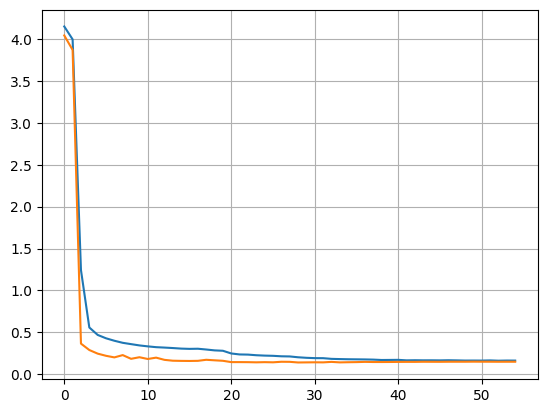

In [4]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()

In [8]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

with torch.no_grad():
    train_mess = []
    train_predicts = []
    for loader in train_dl:
        seq, test_target, _, mess = loader
        train_mess.extend(mess)

        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        train_predicts.extend(predicted_values)

    val_mess = []
    val_predicts = []
    for loader in val_dl:
        seq, test_target, _, mess = loader
        val_mess.extend(mess)

        logits= model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        val_predicts.extend(predicted_values)

import Levenshtein

mean_acc_test = np.mean([Levenshtein.ratio(test_pred, train_mess[ind]) for ind, test_pred in enumerate(train_predicts)])
mean_acc_val = np.mean([Levenshtein.ratio(val_pred, val_mess[ind]) for ind, val_pred in enumerate(val_predicts)])


print(f"Mean accurasu by The Levenshtein in train is : {mean_acc_test}")
print(f"Mean accurasu by The Levenshtein in validate is : {mean_acc_val}")

CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 512
Mean accurasu by The Levenshtein in train is : 0.9320385051013883
Mean accurasu by The Levenshtein in validate is : 0.9479961676379779


# Сбор sample_submission

In [ ]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes)
model_load.load_state_dict(torch.load('MorseNet_0.89.pth'))
model_load.eval()

test_ds = MosreDataset(df=sample_data,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=False,
                        transforms=valid_audio_transforms)


test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False, collate_fn=my_collate)
model_load.eval()

with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        seq = loader
        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)

CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 512


FileNotFoundError: [Errno 2] No such file or directory: 'MorseNet.pth'